In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import digits
from pyvi import ViTokenizer
from keras.models import Model
from keras.layers import (Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer)
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.optimizers import Adamax
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from gensim.models import KeyedVectors
import tensorflow as tf

In [3]:
# ==== SIÊU THAM SỐ ====
MAX_FEATURES = 10000
MAXLEN = 300
BATCH_SIZE = 64
EMBEDDING_DIM = 400
NB_EPOCH = 20

In [4]:
# ==== TIỀN XỬ LÝ DỮ LIỆU ====
def load_data(path="datasets"):
    train_df = pd.read_csv(f"{path}/vlsp_sentiment_train.csv", sep='\t')
    train_df.columns =['Class', 'Text']
    test_df  = pd.read_csv(f"{path}/vlsp_sentiment_test.csv", sep='\t')
    test_df.columns =['Class', 'Text']

    def encode_label(label):
        return [1, 0, 0] if label == -1 else [0, 1, 0] if label == 0 else [0, 0, 1]

    y_train = np.array([encode_label(lbl) for lbl in train_df['Class']])
    y_test  = np.array([encode_label(lbl) for lbl in test_df['Class']])

    def preprocess(text):
        text = ''.join([ch for ch in text if ch not in digits])
        return ViTokenizer.tokenize(text.lower()).split()

    train_tokens = [preprocess(text) for text in train_df['Text']]
    test_tokens  = [preprocess(text) for text in test_df['Text']]

    tokenizer = Tokenizer(num_words=MAX_FEATURES)
    tokenizer.fit_on_texts(train_tokens)

    X_train = pad_sequences(tokenizer.texts_to_sequences(train_tokens), maxlen=MAXLEN)
    X_test  = pad_sequences(tokenizer.texts_to_sequences(test_tokens), maxlen=MAXLEN)

    return X_train, y_train, X_test, y_test, tokenizer.word_index, test_df['Class'].values


In [5]:
# ==== EMBEDDING ====
def create_embedding_layer(word_index, pretrained_path, embedding_dim=400, max_vocab_size=10000, trainable=True):
    word_vectors = KeyedVectors.load_word2vec_format(pretrained_path, binary=True)
    vocab_size = min(len(word_index) + 1, max_vocab_size)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i < max_vocab_size:
            try:
                embedding_matrix[i] = word_vectors[word]
            except KeyError:
                embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)

    return Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     weights=[embedding_matrix],
                     input_length=MAXLEN,
                     trainable=trainable)


In [13]:
from keras.regularizers import l2

# ==== ATTENTION LAYER (giữ nguyên) ====
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.squeeze(ait, -1)
        ait = tf.nn.softmax(ait)
        ait = tf.expand_dims(ait, -1)
        weighted_input = x * ait
        return tf.reduce_sum(weighted_input, axis=1)

# ==== MÔ HÌNH CÓ THÊM REGULARIZATION ====
def build_model(embedding_layer, reg_lambda=0.01):
    input_layer = Input(shape=(MAXLEN,))
    x = embedding_layer(input_layer)
    
    # LSTM với regularization
    x = Bidirectional(
        LSTM(
            100,
            return_sequences=True,
            kernel_regularizer=l2(reg_lambda),
            recurrent_regularizer=l2(reg_lambda)
        )
    )(x)
    
    # Attention
    x = AttentionLayer()(x)
    
    # Dense với regularization
    x = Dense(100, activation='relu', kernel_regularizer=l2(reg_lambda))(x)
    x = Dropout(0.5)(x)
    
    output = Dense(3, activation='softmax', kernel_regularizer=l2(reg_lambda))(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adamax(),
                  metrics=['accuracy'])
    return model


In [16]:
# ==== TRAIN & EVAL ====
def train_and_visualize(pretrained_path):
    X_train, y_train, X_test, y_test, word_index, y_true = load_data()
    embedding_layer = create_embedding_layer(word_index, pretrained_path)

    model = build_model(embedding_layer)
    model.summary()

    print("→ Bắt đầu huấn luyện...")
    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=NB_EPOCH,
                        validation_split=0.1,
                        shuffle=True)

    print("→ Đánh giá mô hình:")
    loss, acc = model.evaluate(X_test, y_test)
    print("✅ Test Accuracy:", acc)

    # ==== BIỂU ĐỒ ====
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss theo Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy theo Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==== CONFUSION MATRIX ====
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true_cls = np.argmax(y_test, axis=1)
    print("\n→ Classification Report:\n", classification_report(y_true_cls, y_pred))

    cm = confusion_matrix(y_true_cls, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
    disp.plot(cmap='Blues')
    plt.show()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 300, 400)          3167600   
                                                                 
 bidirectional_5 (Bidirecti  (None, 300, 200)          400800    
 onal)                                                           
                                                                 
 attention_layer_5 (Attenti  (None, 200)               40400     
 onLayer)                                                        
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0   

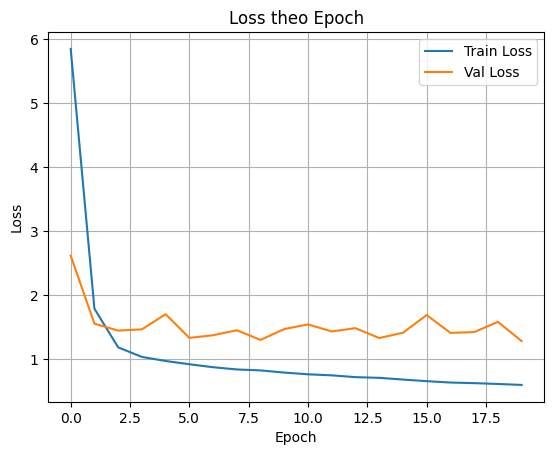

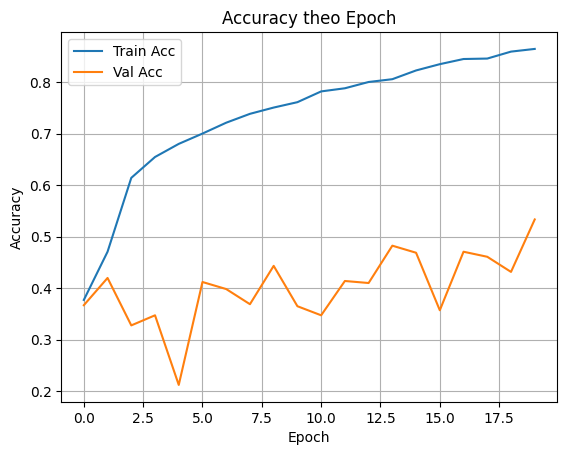

33/33 [==============================] - 2s 56ms/step

→ Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.63      0.65       350
           1       0.58      0.63      0.61       350
           2       0.73      0.69      0.71       350

    accuracy                           0.65      1050
   macro avg       0.66      0.65      0.65      1050
weighted avg       0.66      0.65      0.65      1050



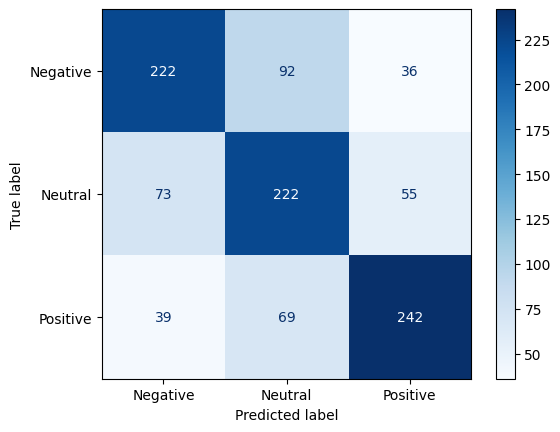

In [17]:
# ==== CHẠY ====
pretrained_path = "datasets/vi-model-CBOW.bin"  # chỉnh lại đường dẫn tương ứng
train_and_visualize(pretrained_path)

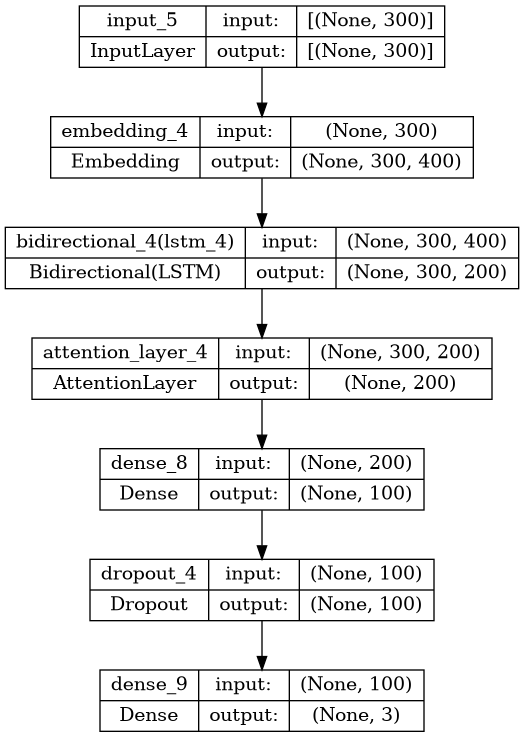

In [15]:
from keras.utils import plot_model
X_train, y_train, X_test, y_test, word_index, y_true = load_data()
embedding_layer = create_embedding_layer(word_index, pretrained_path)

model = build_model(embedding_layer)
# model là đối tượng Keras model đã build sẵn
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
